# Forward inverse rendering

## Overview

The previous example demonstrated *reverse-mode differentiation* (a.k.a. backpropagation) where a desired small change to the output image was converted into a small change to the scene parameters. Mitsuba and Dr.Jit can also propagate derivatives in the other direction, i.e., from input parameters to the output image. This technique, known as *forward mode differentiation*, is typically less suitable for optimization, as the contribution from each parameter must be handled using a separate rendering pass. That said, this mode can be very educational since it enables visualizations of the effect of individual scene parameters on the rendered image.

<div class="admonition important alert alert-block alert-success">

🚀 **What will you learn?**
    
<ul>
  <li>Manually setting variables as differentiable</li>
  <li>Perform forward-mode differentiation with Dr.Jit</li>
  <li>Visualize gradient images with <code>matplotlib</code></li>
</ul>
    
</div>

## Setup

We start by setting an AD-compatible variant (here `llvm_ad_rgb`) and load the Cornell Box scene.

In [1]:
import drjit as dr
import mitsuba as mi

mi.set_variant('llvm_ad_rgb')

scene = mi.load_file('../../scenes/cbox.xml')

## Preparing the scene

Forward mode differentiable rendering begins analogously to reverse mode, by marking the parameters of interest as differentiable (in this example, we do so manually instead of using an `Optimizer`). 

Our goal here is to visualize how changes of the green wall's color affect the final rendered image. Note that we are rendering this image using a physically-based *path tracer*, which means that it accounts for globlal illumination, reflection, refraction, and so on. Gradients computated from this simulation will also expose such effects.

In [2]:
params = mi.traverse(scene)

# Mark the green wall color parameter as differentiable
dr.enable_grad(params['green.reflectance.value'])

# Propagate this change to the scene internal state
params.update();

## Rendering

We can then perform the simulation to be differentiated. In this case, we simply render an image using the `mi.render()` routine, which will in turn call the scene's path tracer integrator.

As we have marked the wall color as *differentiable*, its role in the rendering process is recorded in the autodiff graph.

In [3]:
image = mi.render(scene, params, spp=512)

The [<code>dr.forward()</code>][1] function will assign a gradient value of `1.0` to the given variables and forward-propagate those gradients through the previously recorded computation graph. During this process, gradient will be accumulated in the output nodes of this graph (here, the rendered image).
Finally, the gradients can be read using [<code>dr.grad()</code>][2].

For more detailed information about differentiation with DrJit, please refer to the [documentation][3].

[1]: TODO
[2]: TODO
[3]: TODO

In [4]:
# Forward-propagate gradients through the computation graph
dr.forward(params['green.reflectance.value'])

# Fetch the image gradient values
grad_image = dr.grad(image)

## Visualizing the gradient image

The gradient value of the `image` variable will share the same type (here `TensorXf`) hence it can easily be visualized as any other image.
On the gradient image below, it is interesting to see the *global effect* of the wall color on the rest of the scene.

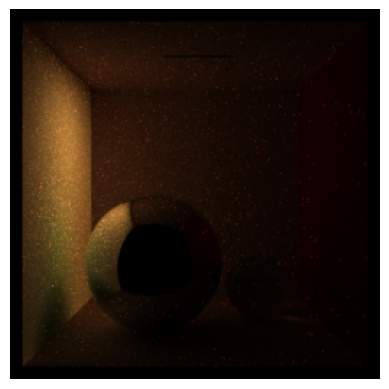

In [5]:
import matplotlib.pyplot as plt
plt.imshow(dr.clamp(grad_image, 0.0, 1.0))
plt.axis('off')
plt.show()

Note however that gradient values are not necessarily within the `[0, 1]` range, and so it makes more sense to use a color map and visualize each color channel of the gradient image individually.

Remapping colors within range: [-1.18, 1.18]


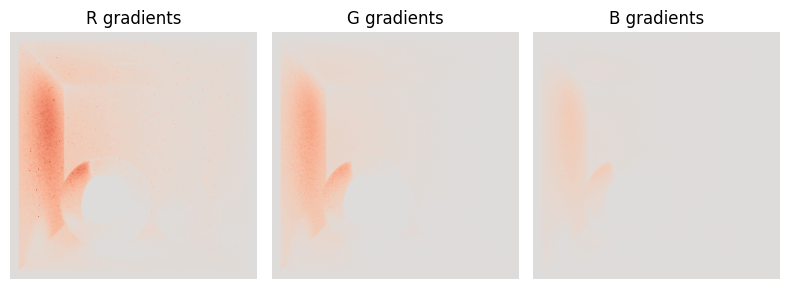

In [6]:
import matplotlib.cm as cm

cmap = cm.coolwarm
vlim = dr.hmax(dr.abs(grad_image))
print(f'Remapping colors within range: [{-vlim:.2f}, {vlim:.2f}]')

fig, axx = plt.subplots(1, 3, figsize=(8, 3))
for i, ax in enumerate(axx):
    ax.imshow(grad_image[..., i], cmap=cm.coolwarm, vmin=-vlim, vmax=vlim)
    ax.set_title('RGB'[i] + ' gradients')
    ax.axis('off')
fig.tight_layout()
plt.show()

## See also

- [<code>mitsuba.ad.Optimizer</code>](https://mitsuba3.readthedocs.io/en/latest/src/api_reference.html#mitsuba.ad.Optimizer)
- [<code>mitsuba.ad.integrators.prb</code>](https://mitsuba3.readthedocs.io/en/latest/src/api_reference.html#mitsuba.ad.integrators.prb)
- [<code>drjit.forward()</code>](...) TODO: link